<a href="https://colab.research.google.com/github/alex-pakalniskis/DS-Unit-1-Sprint-2-Statistics/blob/master/module2/LS_DS_122_Sampling_Confidence_Intervals_and_Hypothesis_Testing_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Assignment - Build a confidence interval

A confidence interval refers to a neighborhood around some point estimate, the size of which is determined by the desired p-value. For instance, we might say that 52% of Americans prefer tacos to burritos, with a 95% confidence interval of +/- 5%.

52% (0.52) is the point estimate, and +/- 5% (the interval $[0.47, 0.57]$) is the confidence interval. "95% confidence" means a p-value $\leq 1 - 0.95 = 0.05$.

In this case, the confidence interval includes $0.5$ - which is the natural null hypothesis (that half of Americans prefer tacos and half burritos, thus there is no clear favorite). So in this case, we could use the confidence interval to report that we've failed to reject the null hypothesis.

But providing the full analysis with a confidence interval, including a graphical representation of it, can be a helpful and powerful way to tell your story. Done well, it is also more intuitive to a layperson than simply saying "fail to reject the null hypothesis" - it shows that in fact the data does *not* give a single clear result (the point estimate) but a whole range of possibilities.

How is a confidence interval built, and how should it be interpreted? It does *not* mean that 95% of the data lies in that interval - instead, the frequentist interpretation is "if we were to repeat this experiment 100 times, we would expect the average result to lie in this interval ~95 times."

For a 95% confidence interval and a normal(-ish) distribution, you can simply remember that +/-2 standard deviations contains 95% of the probability mass, and so the 95% confidence interval based on a given sample is centered at the mean (point estimate) and has a range of +/- 2 (or technically 1.96) standard deviations.

Different distributions/assumptions (90% confidence, 99% confidence) will require different math, but the overall process and interpretation (with a frequentist approach) will be the same.

Your assignment - using the data from the prior module ([congressional voting records](https://archive.ics.uci.edu/ml/datasets/Congressional+Voting+Records)):


### Confidence Intervals:
1. Generate and numerically represent a confidence interval


In [0]:
# TODO - your code!

### Import libraries for assignment

In [0]:
import pandas as pd

from scipy import stats

import numpy as np

import matplotlib.pyplot as plt

import seaborn as sns

### Load data with pandas `read_csv` function. 
Data are from UCI Machine Learning Data Repository

In [2]:
data_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/voting-records/house-votes-84.data"

data_headers = ['party','handicapped-infants','water-project',
                          'budget','physician-fee-freeze', 'el-salvador-aid',
                          'religious-groups','anti-satellite-ban',
                          'aid-to-contras','mx-missile','immigration',
                          'synfuels', 'education', 'right-to-sue','crime','duty-free',
                          'south-africa']

df = pd.read_csv(data_url, names=data_headers)

df.head()

,party,handicapped-infants,water-project,budget,physician-fee-freeze,el-salvador-aid,religious-groups,anti-satellite-ban,aid-to-contras,mx-missile,immigration,synfuels,education,right-to-sue,crime,duty-free,south-africa
0,republican,n,y,n,y,y,y,n,n,n,y,?,y,y,y,n,y
1,republican,n,y,n,y,y,y,n,n,n,n,n,y,y,y,n,?
2,democrat,?,y,y,?,y,y,n,n,n,n,y,n,y,y,n,n
3,democrat,n,y,y,n,?,y,n,n,n,n,y,n,y,n,n,y
4,democrat,y,y,y,n,y,y,n,n,n,n,y,?,y,y,y,y


### Convert "y", "n", and "?" to 1, 0, and np.NaN, respectively

In [3]:
df = df.replace({"y":1,"n":0,"?":np.NaN})

df.head()

,party,handicapped-infants,water-project,budget,physician-fee-freeze,el-salvador-aid,religious-groups,anti-satellite-ban,aid-to-contras,mx-missile,immigration,synfuels,education,right-to-sue,crime,duty-free,south-africa
0,republican,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,NaN,1.0,1.0,1.0,0.0,1.0
1,republican,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,NaN
2,democrat,NaN,1.0,1.0,NaN,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0
3,democrat,0.0,1.0,1.0,0.0,NaN,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
4,democrat,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,NaN,1.0,1.0,1.0,1.0


In [0]:
republicans = df[df["party"] == "republican"]

democrats = df[df["party"] == "democrat"]

### Define some functions to process the data

In [0]:
def mean_moe(sample, confidence=0.95):
  """
  Calculate a sample mean and margin of error for given data.
  Using t-distribution and two-tailed test, default 95% confidence. 
  
  Arguments:
    sample - iterable (list or numpy array) of sample observations
    confidence - level of confidence for the interval
  
  Returns:
    tuple of (mean, margin_of_error)
  """
  # Broadcast to array
  sample = np.array(sample)
  # Remove NaN values
  sample = sample[~np.isnan(sample)]
  # Calculate sample mean
  mean = np.mean(sample)
  # Calculate sample size
  n = len(sample)
  # Calculate standard error
  stderr = np.std(sample, ddof=1) / np.sqrt(n)
  # Look up the t-statistic that contains 95% of possible sample means within its bounds
  t = stats.t.ppf((1 + confidence) / 2.0, n-1)
  # Margin of error 
  margin_of_error = t * stderr
  return mean, margin_of_error

def confidence_interval(sample, confidence=0.95):
  """
  Calculate a confidence interval around a sample mean for given data.
  Using t-distribution and two-tailed test, default 95% confidence. 
  
  Arguments:
    sample - iterable (list or numpy array) of sample observations
    confidence - level of confidence for the interval
  
  Returns:
    tuple of (lower bound, mean, upper bound)
  """
  # Broadcast to NumPy array
  sample = np.array(sample)
  # Remove NaN values
  sample = sample[~np.isnan(sample)]
  # Sample mean
  mean = np.mean(sample)
  # Sample size
  n = len(sample)
  # Standard error
  stderr = np.std(sample, ddof=1) / np.sqrt(n)
  # T-statistic that contains 95% of possible sample means within its bounds
  t = stats.t.ppf((1 + confidence) / 2.0, n-1)
  # Margin of error 
  margin_of_error = t * stderr
  return mean - margin_of_error, mean, mean + margin_of_error

In [70]:
#republican population mean
print(republicans["immigration"].mean())

#democrat population mean
print(democrats["immigration"].mean())

0.5575757575757576
0.4714828897338403


In [0]:
republicans_sample = republicans["immigration"].sample(int(len(republicans)*0.25))

democrats_sample = democrats["immigration"].sample(int(len(democrats)*0.25))


In [86]:
confidence_interval(republicans_sample)

(0.40238815443940157, 0.5609756097560976, 0.7195630650727937)

In [87]:
confidence_interval(democrats_sample)

(0.36746436593740384, 0.49230769230769234, 0.6171510186779808)

2. Graphically (with a plot) represent the confidence interval


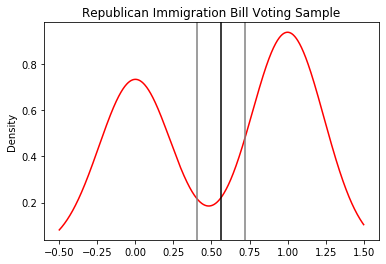

In [88]:
republicans_sample.plot.density(color="red")
plt.title("Republican Immigration Bill Voting Sample")
plt.axvline(x=confidence_interval(republicans_sample)[0], color='gray')
plt.axvline(x=confidence_interval(republicans_sample)[1], color='black')
plt.axvline(x=confidence_interval(republicans_sample)[2], color='gray');

plt.show()

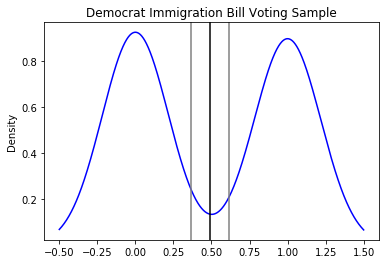

In [89]:
democrats_sample.plot.density(color="blue")
plt.title("Democrat Immigration Bill Voting Sample")
plt.axvline(x=confidence_interval(democrats_sample)[0], color='gray')
plt.axvline(x=confidence_interval(democrats_sample)[1], color='black')
plt.axvline(x=confidence_interval(democrats_sample)[2], color='gray');

plt.show()

3. Interpret the confidence interval - what does it tell you about the data and its distribution?




The confidence interval is used to frame the significance of sample statistics such as t-tests for hypothesis testing. It is an estimate of a population parameter, i.e. the mean.

Confidence intervals are used to communicate the precision with which we are estimating said population parameter.

Given the sample we have taken, this is where the mean (population parameter) is.

### Chi-squared tests:
4. Take a dataset that we have used in the past in class that has **categorical** variables. Pick two of those categorical variables and run a chi-squared tests on that data
- By hand using Numpy

**Null hypothesis**: Forest fire month and forest fire day of week are independent.

**Alternative hypothesis**: Forest fire month and forest fire day of week are not independent.

**Confidence interval**: 95%
  

In [48]:
fires_df = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/forest-fires/forestfires.csv")

fires_df

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
0,7,5,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.00
1,7,4,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.00
2,7,4,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.00
3,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.00
4,8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
512,4,3,aug,sun,81.6,56.7,665.6,1.9,27.8,32,2.7,0.0,6.44
513,2,4,aug,sun,81.6,56.7,665.6,1.9,21.9,71,5.8,0.0,54.29
514,7,4,aug,sun,81.6,56.7,665.6,1.9,21.2,70,6.7,0.0,11.16
515,1,4,aug,sat,94.4,146.0,614.7,11.3,25.6,42,4.0,0.0,0.00


In [102]:
fires_contingency_table = pd.crosstab(fires_df["month"], fires_df["day"], margins=True)

fires_contingency_table

day,fri,mon,sat,sun,thu,tue,wed,All
month,,,,,,,,
apr,1,1,1,3,2,0,1,9
aug,21,15,29,40,26,28,25,184
dec,1,4,0,1,1,1,1,9
feb,5,3,4,4,1,2,1,20
jan,0,0,1,1,0,0,0,2
jul,3,4,8,5,3,6,3,32
jun,3,3,2,4,2,0,3,17
mar,11,12,10,7,5,5,4,54
may,1,0,1,0,0,0,0,2


In [106]:
fires_row_sums = fires_contingency_table.iloc[0:-1,-1].values

fires_row_sums

array([  9, 184,   9,  20,   2,  32,  17,  54,   2,   1,  15, 172])

In [107]:
fires_col_sums = fires_contingency_table.iloc[-1, 0:-1].values

fires_col_sums

array([85, 74, 84, 95, 61, 64, 54])

In [108]:
total_total = fires_df.shape[0]

total_total

517

In [110]:
expected = []
for i in range(len(fires_row_sums)):
  expected_row = []
  for column in fires_col_sums:
    expected_val = column * fires_row_sums[i]/total_total
    expected_row.append(expected_val)
  expected.append(expected_row)

expected = np.array(expected)
print(expected.shape)
print(expected)

(12, 7)
[[ 1.47969052  1.28820116  1.4622824   1.65377176  1.06189555  1.11411992
   0.94003868]
 [30.25145068 26.33655706 29.89555126 33.81044487 21.7098646  22.77756286
  19.21856867]
 [ 1.47969052  1.28820116  1.4622824   1.65377176  1.06189555  1.11411992
   0.94003868]
 [ 3.28820116  2.86266925  3.24951644  3.67504836  2.35976789  2.47582205
   2.08897485]
 [ 0.32882012  0.28626692  0.32495164  0.36750484  0.23597679  0.24758221
   0.20889749]
 [ 5.26112186  4.58027079  5.19922631  5.88007737  3.77562863  3.96131528
   3.34235977]
 [ 2.79497099  2.43326886  2.76208897  3.1237911   2.00580271  2.10444874
   1.77562863]
 [ 8.87814313  7.72920696  8.77369439  9.92263056  6.37137331  6.68471954
   5.64023211]
 [ 0.32882012  0.28626692  0.32495164  0.36750484  0.23597679  0.24758221
   0.20889749]
 [ 0.16441006  0.14313346  0.16247582  0.18375242  0.11798839  0.1237911
   0.10444874]
 [ 2.46615087  2.14700193  2.43713733  2.75628627  1.76982592  1.85686654
   1.56673114]
 [28.27852998 

In [111]:
# Get a crosstab without the margins:
observed = pd.crosstab(fires_df["month"], fires_df["day"]).values

observed

array([[ 1,  1,  1,  3,  2,  0,  1],
       [21, 15, 29, 40, 26, 28, 25],
       [ 1,  4,  0,  1,  1,  1,  1],
       [ 5,  3,  4,  4,  1,  2,  1],
       [ 0,  0,  1,  1,  0,  0,  0],
       [ 3,  4,  8,  5,  3,  6,  3],
       [ 3,  3,  2,  4,  2,  0,  3],
       [11, 12, 10,  7,  5,  5,  4],
       [ 1,  0,  1,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  1,  0],
       [ 1,  4,  3,  3,  0,  2,  2],
       [38, 28, 25, 27, 21, 19, 14]])

In [112]:
chi_squared = ((observed - expected)**2 / expected).sum()

print(chi_squared)

64.2383177767438


  - In a single line using Scipy

In [113]:
chi2_stat, p_value, dof, expected = stats.chi2_contingency(observed)

print("chi2_stat:", chi2_stat)

print("p_value:",p_value)

print("dof:",dof)

print("expected:",expected)

chi2_stat: 64.2383177767438
p_value: 0.5384475410453669
dof: 66
expected: [[ 1.47969052  1.28820116  1.4622824   1.65377176  1.06189555  1.11411992
   0.94003868]
 [30.25145068 26.33655706 29.89555126 33.81044487 21.7098646  22.77756286
  19.21856867]
 [ 1.47969052  1.28820116  1.4622824   1.65377176  1.06189555  1.11411992
   0.94003868]
 [ 3.28820116  2.86266925  3.24951644  3.67504836  2.35976789  2.47582205
   2.08897485]
 [ 0.32882012  0.28626692  0.32495164  0.36750484  0.23597679  0.24758221
   0.20889749]
 [ 5.26112186  4.58027079  5.19922631  5.88007737  3.77562863  3.96131528
   3.34235977]
 [ 2.79497099  2.43326886  2.76208897  3.1237911   2.00580271  2.10444874
   1.77562863]
 [ 8.87814313  7.72920696  8.77369439  9.92263056  6.37137331  6.68471954
   5.64023211]
 [ 0.32882012  0.28626692  0.32495164  0.36750484  0.23597679  0.24758221
   0.20889749]
 [ 0.16441006  0.14313346  0.16247582  0.18375242  0.11798839  0.1237911
   0.10444874]
 [ 2.46615087  2.14700193  2.43713733

**Conclusions**: 

Given a $\chi^2$ statistic of 64.24, a $\text{p value}$ of 0.5384, 66 degrees of freedom, and a confidence interval of 95%, I fail to reject the null hypothesis that forest fire month and forest fire day of week are independent.

## Stretch goals:

1. Write a summary of your findings, mixing prose and math/code/results. *Note* - yes, this is by definition a political topic. It is challenging but important to keep your writing voice *neutral* and stick to the facts of the data. Data science often involves considering controversial issues, so it's important to be sensitive about them (especially if you want to publish).








2. Apply the techniques you learned today to your project data or other data of your choice, and write/discuss your findings here.


3. Refactor your code so it is elegant, readable, and can be easily run for all issues.

In [114]:
issues = df.drop(["party"], axis=1).columns.tolist()
issues

['handicapped-infants',
 'water-project',
 'budget',
 'physician-fee-freeze',
 'el-salvador-aid',
 'religious-groups',
 'anti-satellite-ban',
 'aid-to-contras',
 'mx-missile',
 'immigration',
 'synfuels',
 'education',
 'right-to-sue',
 'crime',
 'duty-free',
 'south-africa']

In [0]:
def sample_confidence_intervals(pandas_series, sample_size, confidence=0.95):
  # Sample the input Series
  sample = pandas_series.sample(int(sample_size))
# Broadcast to NumPy array
  sample = np.array(sample)
  # Remove NaN values
  sample = sample[~np.isnan(sample)]
  # Sample mean
  mean = np.mean(sample)
  # Sample size
  n = len(sample)
  # Standard error
  stderr = np.std(sample, ddof=1) / np.sqrt(n)
  # T-statistic that contains 95% of possible sample means within its bounds
  t = stats.t.ppf((1 + confidence) / 2.0, n-1)
  # Margin of error 
  margin_of_error = t * stderr
  return mean, margin_of_error

In [145]:
republicans_CI = []

for i in range(len(issues)):
  
  republicans_CI.append(sample_confidence_intervals(republicans[issues[i]], 
                                    
                                                    len(republicans)*0.25))

republicans_confidence_intervals_df = pd.DataFrame(republicans_CI, 
                                                    
                                                   columns=["Mean",
                                                             
                                                            "Margin of Error"])
  
republicans_confidence_intervals_df["issue"] = pd.Series(issues)

republicans_confidence_intervals_df["party"] = "Republican"

  
republicans_confidence_intervals_df

,Mean,Margin of Error,issue,party
0,0.097561,0.094820,handicapped-infants,Republican
1,0.550000,0.161133,water-project,Republican
2,0.200000,0.129556,budget,Republican
3,1.000000,0.000000,physician-fee-freeze,Republican
4,0.902439,0.094820,el-salvador-aid,Republican
5,0.926829,0.083219,religious-groups,Republican
6,0.150000,0.115652,anti-satellite-ban,Republican
7,0.250000,0.140248,aid-to-contras,Republican
8,0.146341,0.112948,mx-missile,Republican
9,0.536585,0.159352,immigration,Republican


In [146]:
democrats_CI = []

for i in range(len(issues)):
  
  democrats_CI.append(sample_confidence_intervals(democrats[issues[i]], 
                                    
                                                    len(democrats)*0.25))

democrats_confidence_intervals_df = pd.DataFrame(democrats_CI, 
                                                    
                                                 columns=["Mean",
                                                             
                                                          "Margin of Error"])
  
democrats_confidence_intervals_df["issue"] = pd.Series(issues)

democrats_confidence_intervals_df["party"] = "Democrat"

democrats_confidence_intervals_df

,Mean,Margin of Error,issue,party
0,0.557377,0.128266,handicapped-infants,Democrat
1,0.590164,0.127002,water-project,Democrat
2,0.892308,0.077410,budget,Democrat
3,0.062500,0.060943,physician-fee-freeze,Democrat
4,0.218750,0.104080,el-salvador-aid,Democrat
5,0.446154,0.124132,religious-groups,Democrat
6,0.723077,0.111743,anti-satellite-ban,Democrat
7,0.781250,0.104080,aid-to-contras,Democrat
8,0.825397,0.096376,mx-missile,Democrat
9,0.500000,0.125884,immigration,Democrat


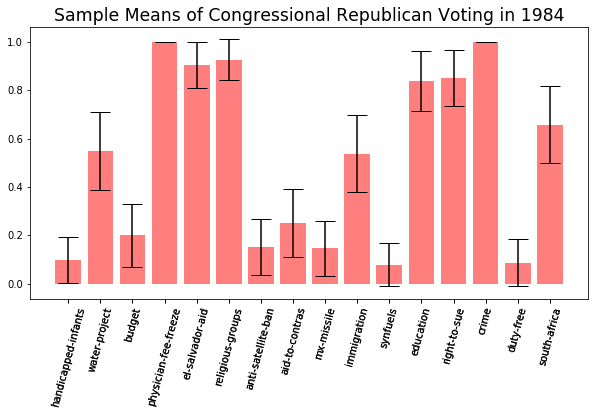

In [177]:
fig, ax = plt.subplots(figsize=(10,5))

ax.bar(republicans_confidence_intervals_df.index, republicans_confidence_intervals_df["Mean"],
       yerr=republicans_confidence_intervals_df["Margin of Error"],
       align='center',
       alpha=0.5,
       ecolor='black',
       capsize=10, facecolor="red")

plt.xticks(rotation=75)
ax.set_xticks(df_confidence_intervals.index)
ax.set_xticklabels(df_confidence_intervals["issue"].tolist())

plt.title("Sample Means of Congressional Republican Voting in 1984", size="xx-large")
plt.show()

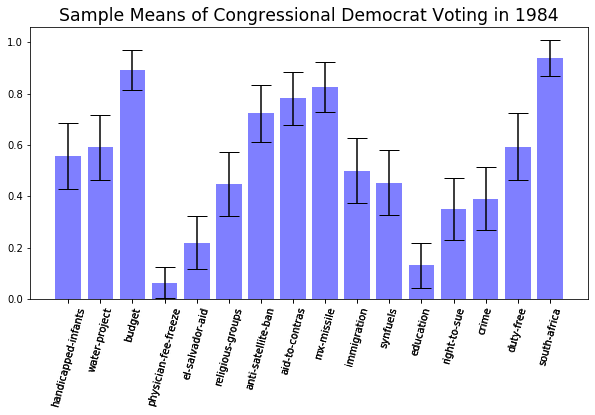

In [179]:
fig, ax = plt.subplots(figsize=(10,5))

ax.bar(democrats_confidence_intervals_df.index, democrats_confidence_intervals_df["Mean"],
       yerr=democrats_confidence_intervals_df["Margin of Error"],
       align='center',
       alpha=0.5,
       ecolor='black',
       capsize=10, facecolor="blue")

plt.xticks(rotation=75)
ax.set_xticks(df_confidence_intervals.index)
ax.set_xticklabels(df_confidence_intervals["issue"].tolist())

plt.title("Sample Means of Congressional Democrat Voting in 1984", size="xx-large")
plt.show()

## Resources

- [Interactive visualize the Chi-Squared test](https://homepage.divms.uiowa.edu/~mbognar/applets/chisq.html)
- [Calculation of Chi-Squared test statistic](https://en.wikipedia.org/wiki/Pearson%27s_chi-squared_test)
- [Visualization of a confidence interval generated by R code](https://commons.wikimedia.org/wiki/File:Confidence-interval.svg)
- [Expected value of a squared standard normal](https://math.stackexchange.com/questions/264061/expected-value-calculation-for-squared-normal-distribution) (it's 1 - which is why the expected value of a Chi-Squared with $n$ degrees of freedom is $n$, as it's the sum of $n$ squared standard normals)